In [10]:
import pandas as pd  # pip install pandas
import numpy as np  # pip install numpy
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import random
import ast
import statsmodels.api as sm

df_test = pd.read_csv('../supplementary_data/test_data.csv')
df_test.head()

,Unnamed: 0,name,version,num_reviews,issues_closed,center_datetime,filtered_reviews
0,quran-_-quran_android,quran-_-quran_android,3.0.0,3199.5,61,2020-04-10 21:29:00+00:00,"{13498: {'score': 5, 'reviewCreatedVersion': '..."
1,AdguardTeam-_-ContentBlocker,AdguardTeam-_-ContentBlocker,2.0.0,1567.5,16,2018-02-01 14:56:29+00:00,"{6224: {'score': 5, 'reviewCreatedVersion': '2..."
2,iSoron-_-uhabits,iSoron-_-uhabits,2.0.3,1529.5,146,2021-08-21 11:39:47+00:00,"{2824: {'score': 5, 'reviewCreatedVersion': '2..."
3,romannurik-_-muzei,romannurik-_-muzei,3.0.0,1327.5,561,2018-10-14 03:17:43+00:00,"{528: {'score': 5, 'reviewCreatedVersion': '3...."
4,physphil-_-UnitConverterUltimate,physphil-_-UnitConverterUltimate,5.0,532.5,13,2016-11-07 02:35:11+00:00,"{1181: {'score': 4, 'reviewCreatedVersion': '5..."


In [19]:
delta_scores = []
cutoff= df_test['issues_closed'].median() # Average, idk if this is the best choice

for index in range(len(df_test)):
    app_test = df_test.loc[index]
    reviews_test = ast.literal_eval(app_test['filtered_reviews'])
    df_app = pd.DataFrame(reviews_test).T
    average_score_before = sum(df_app[df_app['deltadays'] > 0]['score']) / len(df_app[df_app['deltadays'] > 0]['score'])
    average_score_after = sum(df_app[df_app['deltadays'] <= 0]['score']) / len(df_app[df_app['deltadays'] <= 0]['score'])
    delta_scores.append(average_score_after - average_score_before)

df_test['delta_scores'] = delta_scores
df_test['treatment'] = (df_test['issues_closed'] >= cutoff).astype(int)
df_test['delta_issues'] = df_test['issues_closed'] - cutoff
df_test['interaction'] = df_test['treatment'] * df_test['delta_issues']
len(df_test)

74

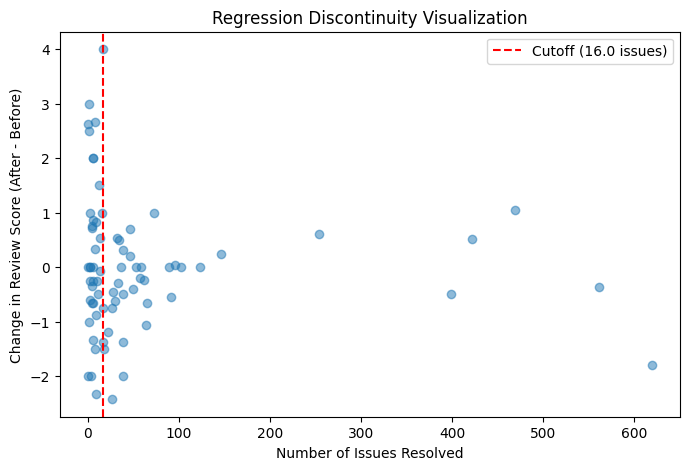

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(df_test['issues_closed'], df_test['delta_scores'], alpha=0.5)
plt.axvline(x=cutoff, color='red', linestyle='--', label='Cutoff ({} issues)'.format(cutoff))
plt.xlabel("Number of Issues Resolved")
plt.ylabel("Change in Review Score (After - Before)")
plt.title("Regression Discontinuity Visualization")
plt.legend()
plt.show()

In [21]:
X = df_test[['treatment', 'delta_issues', 'interaction']]
X = sm.add_constant(X)  # Intercept
y = df_test['delta_scores']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_scores   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8529
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.470
Time:                        14:13:19   Log-Likelihood:                -118.55
No. Observations:                  74   AIC:                             245.1
Df Residuals:                      70   BIC:                             254.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1420      0.574      0.247   